**Aprendizado Supervisionado de Modelos Paramétricos - Universidade Federal do Rio Grande do Sul**

# Trabalho 1 - Regressão por Mínimos Quadrados

**Previsão da Carga Mensal de Energia Brasileira**

Guilherme de Paoli Beal

Porto Alegre, 10 de abril de 2023

## Objetivos
* Modelar o consumo de energia no Brasil com uma regressão linear
* Identificar os parâmetros do modelo minimizando o erro quadrático médio de predição
  * Implementação por batelada
  * Implementação recursiva
  * Validação cruzada

## Autorregressão

$$
\hat{y}(t) = \theta_0 + \theta_1 \, y(t-1) + \theta_2 \, y(t-2) + \dotsb + \theta_N \, y(t-N)
$$

# Base de Dados

## ONS

**O que é ONS?**

> O Operador Nacional do Sistema Elétrico (ONS) é o órgão responsável pela coordenação e controle da operação das instalações de geração e transmissão de energia elétrica no Sistema Interligado Nacional (SIN) e pelo planejamento da operação dos sistemas isolados do país, sob a fiscalização e regulação da Agência Nacional de Energia Elétrica (ANEEL).
>
> \[...\]
>
> O ONS é composto por membros associados e membros participantes, que são as empresas de geração, transmissão, distribuição, consumidores livres, importadores e exportadores de energia. Também participam o Ministério de Minas e Energia (MME) e representantes dos Conselhos de Consumidores.
>
> Fonte: <cite><https://www.ons.org.br/paginas/sobre-o-ons/o-que-e-ons></cite>

**Fundação:** 26 de agosto de 1998 (25 anos)

## Portal de Dados Abertos do ONS

> O Portal de Dados Abertos do ONS reúne dados históricos do setor elétrico brasileiro de maneira fácil e democrática. Lançado em agosto de 2021, em comemoração aos 23 anos do ONS, o Portal tem como principal objetivo facilitar, melhorar, democratizar o acesso e consumo desse tipo de conteúdo por todos os seus usuários e públicos. Trazendo diversos conjuntos de dados, o site garante disponibilidade de acesso, reuso e redistribuição e participação universal.
>
> \[...\]
> 
> Atualmente, temos disponíveis os conjuntos de dados históricos:
> 
> * Balanço de Energia Dessem
> * Balanço de Energia nos Subsistemas
> * Capacidade Instalada de Geração
> * Capacidade de Transformação da Rede Básica
> * **Carga de Energia**
> * CMO Semanal
> * CMO Semi-Horário
> * Curva de Carga Horária
> * CVU das Usinas Térmicas
> * Contornos das Bacias Hidrográficas
> * Dados Hidrológicos de Reservatórios
> * EAR Diário por Bacia
> * EAR Diário por REE - Reservatório Equivalente de Energia
> * EAR Diário por Reservatório
> * EAR Diário por Subsistema
> * ENA Diário por Bacia
> * ENA Diário por REE - Reservatório Equivalente de Energia
> * ENA Diário por Reservatório
> * ENA Diário por Subsistema
> * Energia Vertida Turbinável
> * Equipamentos de Controle de Reativos da Rede de Operação
> * Fator de Capacidade de Geração Eólica e Solar-2
> * Geração por Usina em Base Horária-2
> * Geração Térmica por Motivo de Despacho-2
> * Grandezas Fluviométricas
> * Importação de Energia na Modalidade Comercial por Bloco
> * Indicadores de Disponibilidade de Função Geração
> * Indicador de Disponibilidade de Função Transmissão – Equipamentos de Controle de Reativo
> * Indicador de Disponibilidade de Função Transmissão – Conversores
> * Indicador de Disponibilidade de Função Transmissão – Linhas de Transmissão e Transformadores
> * Intercâmbios Entre Subsistemas
> * Intercâmbio do SIN com Outros Países
> * Linhas de Transmissão da Rede de Operação
> * Ofertas de Preço para Importação
> * Reservatórios
> * Restrição de Operação por Constrained-off de Usinas Eólicas
> * Restrição de Operação por Constrained-off de Usinas Eólicas - Detalhamento por Usina
> 
> Fonte: <cite><https://dados.ons.org.br></cite>

### Carga de Energia

> Dados de carga por subsistema numa data de referência em base diária, medido em MWmed.
>
> Fonte: <cite>https://dados.ons.org.br/dataset/carga-energia</cite>

**Formatos:**
* **.csv**
* .xsls

**Campos:**

|              Descrição              |         Código        | Tipo de Dado |        Formato       |
|:-----------------------------------:|:---------------------:|:------------:|:--------------------:|
|         Código do Subsistema        |     id_subsistema     |     TEXTO    |      3 POSIÇÕES      |
|          Nome do Subsistema         |     nom_subsistema    |     TEXTO    |      20 POSIÇÕES     |
|          Data de referência         |      din_instante     |   DATETIME   | YYYY-MM-DD HH:MM:SS  |
| Valor da Carga de Energia, em MWmed | val_cargaenergiamwmed |     FLOAT    |                      |

**Data de Início:** 01 de janeiro de 2000

**Data de Término:** alguns dias antes da data atual

#### O que é MWmed?

Unidade de potência média.

Definição:
$1 \,\text{MWmed}=\dfrac{1 \,\text{MWh}}{\Delta t}$

Na base diária:
$1 \,\text{MWmed}=\dfrac{1 \,\text{MWh}}{24 \,\text{h}}$

#### O que é um subsistema?

> O sistema de produção e transmissão de energia elétrica do Brasil é um sistema hidro-termo-eólico de grande porte, com predominância de usinas hidrelétricas e com múltiplos proprietários. O Sistema Interligado Nacional é constituído por quatro subsistemas: **Sul, Sudeste/Centro-Oeste, Nordeste e a maior parte da região Norte**.
> 
> Fonte: <cite>https://www.ons.org.br/paginas/sobre-o-sin/o-que-e-o-sin</cite>

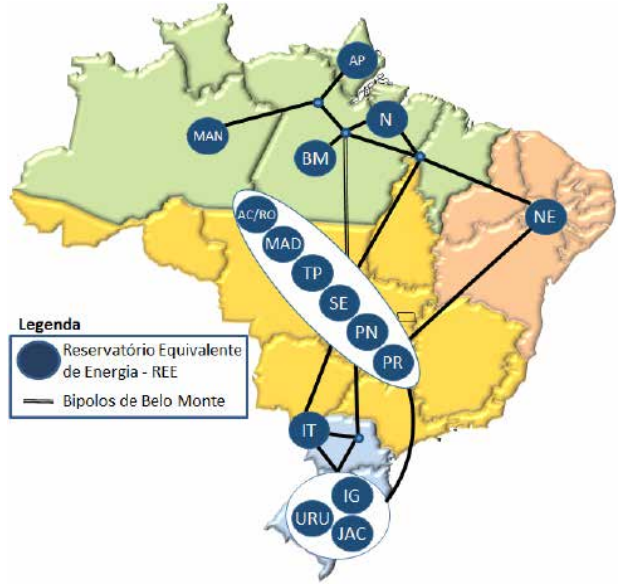

Fonte: <cite>https://www.ons.org.br/AcervoDigitalDocumentosEPublicacoes/PEN_Executivo_2019-2023.pdf</cite>

### Download dos Dados

In [1]:
import os
from urllib import request

force_download = False # Force files to be redownloaded

base_url  = "https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/"
dataset   = "carga_energia_di/"
file_name = "CARGA_ENERGIA_{year}.csv"

raw_data_folder = "data/raw/"

year_start = 2000
year_end   = 2023

if not os.path.exists(raw_data_folder):
  os.makedirs(raw_data_folder)

for year in range(year_start, year_end+1):
  source_file = file_name.format(year=year)
  url = base_url + dataset + source_file
  save_file = raw_data_folder + source_file
  if not os.path.isfile(save_file) or force_download:
    print("Downloading file: ", source_file)
    request.urlretrieve(url, save_file)

# Tratamento dos Dados

### Consolidação dos Arquivos

In [2]:
import os
import pandas as pd

raw_data_folder = "data/raw/"
file_name = "CARGA_ENERGIA_{year}.csv"

year_start = 2000
year_end   = 2023

df = [] # Import files into array
for year in range(year_start, year_end+1):
  file = raw_data_folder + file_name.format(year=year)
  df.append(pd.read_csv(file, sep=";", encoding="utf-8", parse_dates=["din_instante"]))
df = pd.concat(df) # Concat array into single dataframe

df.drop(columns=["nom_subsistema"], inplace=True)
df.rename(columns={"id_subsistema": "region", "din_instante": "timestamp", "val_cargaenergiamwmed": "load"}, inplace=True)
df.set_index(["timestamp", "region"], inplace=True)

display(df)

load
timestamp  region              
2000-01-01 N        2243.512500
           NE       4646.370833
           S        4800.650000
           SE      19045.995833
2000-01-02 N        2259.808333
...                         ...
2023-04-05 SE      43308.653042
2023-04-06 N                NaN
           NE               NaN
           S                NaN
           SE               NaN

[33989 rows x 1 columns]

## Limpeza dos Dados

In [3]:
clean_data_folder = "data/clean/"

display(df[df.load.isnull()])

# Remove entries whose timestamps are time different of "00:00:00"
df = df[(df.index.get_level_values(0).hour   == 0) & 
        (df.index.get_level_values(0).minute == 0) &
        (df.index.get_level_values(0).second == 0)]

# Remove entries from 2023
df = df[df.index.get_level_values(0).year < 2023]

if not os.path.exists(clean_data_folder):
  os.makedirs(clean_data_folder)

df.to_csv(clean_data_folder + "data.csv")

load
timestamp           region      
2013-02-02 00:00:01 S        NaN
2013-12-01 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN
2014-02-01 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN
2015-04-09 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN
2016-04-05 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN
2016-04-06 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN
2016-04-07 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN
2016-04-08 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN
2016-04-09 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN
2016-04-10 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN
2016-04-11 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN
2016-04-12 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN
2016-04-13 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN
2023-04-06 00:00:00 N        NaN
                    NE       NaN
                    S        NaN
                    SE       NaN

## Consolidação por Região

In [4]:
fig_folder = "fig/"

if not os.path.exists(fig_folder):
  os.makedirs(fig_folder)

,load
timestamp,
2000-01-01,30736.529167
2000-01-02,31453.354167
2000-01-03,37466.737500
2000-01-04,39149.970833
2000-01-05,39961.879167
...,...
2022-12-27,67468.478417
2022-12-28,67361.841167
2022-12-29,66510.932542


,load
timestamp,
2013-12-01,NaN
2014-02-01,NaN
2015-04-09,NaN
2016-04-05,NaN
2016-04-06,NaN
2016-04-07,NaN
2016-04-08,NaN
2016-04-09,NaN
2016-04-10,NaN


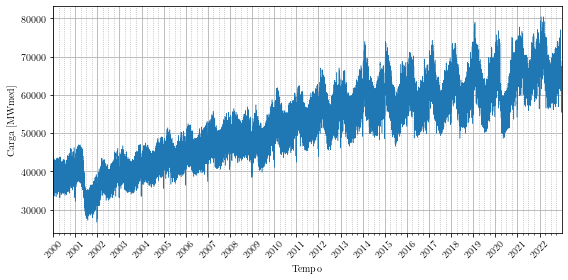

In [5]:
import numpy as np
from functions import plot_data

region = "BR"

if not region or region == "BR":
  region = "BR"
  df_R = df.groupby(["timestamp"])["load"].sum().to_frame().copy()
  df_R.load.replace(0, np.nan, inplace=True)
else:
  df_R = df.loc[df.index.get_level_values(1) == region].copy()
  df_R.reset_index(level=["region"],inplace=True,drop=True)

display(df_R)
display(df_R[df_R.load.isnull()])
plot_data(df_R.index, df_R.load, ylabel="Carga [MWmed]", linewidth=0.5, saveFileName=fig_folder+f"data_{region}_day")
df_R.to_csv(clean_data_folder + f"data_{region}.csv")

## Consolidação Mensal

### Total

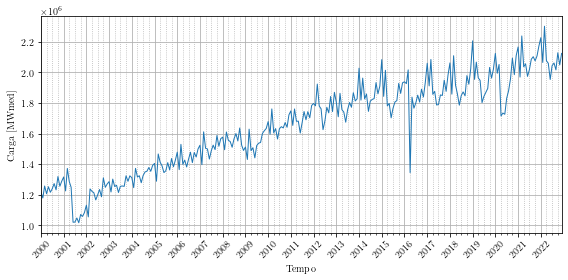

In [6]:
df_R_M_T = df_R.resample(rule="MS").sum() # Resample and sum

# display(df_R_M_T)
plot_data(df_R_M_T.index, df_R_M_T.load, ylabel="Carga [MWmed]")
df_R_M_T.to_csv(clean_data_folder + f"data_{region}_month_total.csv")

### Média

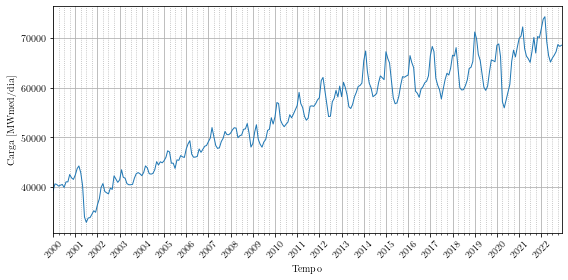

In [7]:
df_R_M_M = df_R.resample(rule="MS").mean() # Resample and mean

# display(df_R_M_M)
plot_data(df_R_M_M.index, df_R_M_M.load, saveFileName=fig_folder+f"data_{region}_month_mean")
df_R_M_M.to_csv(clean_data_folder + f"data_{region}_month_mean.csv")

## Consolidação Anual

### Total

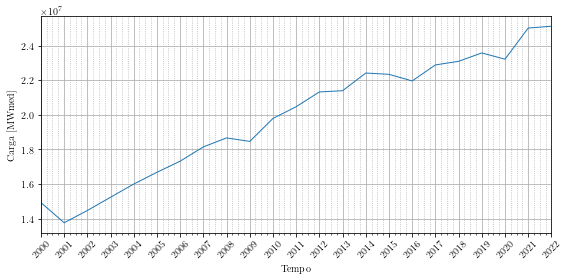

In [8]:
df_R_Y_T = df_R.resample(rule="YS").sum() # Resample and sum

# display(df_R_Y_T)
plot_data(df_R_Y_T.index, df_R_Y_T.load, ylabel="Carga [MWmed]")
df_R_Y_T.to_csv(clean_data_folder + f"data_{region}_year_total.csv")

### Média

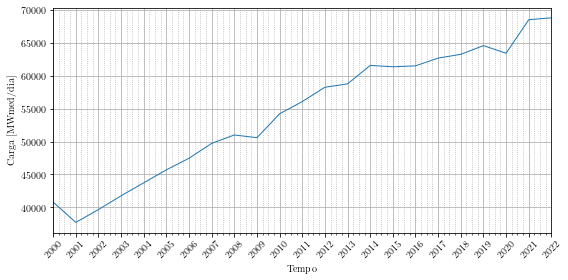

In [9]:
df_R_Y_M = df_R.resample(rule="YS").mean() # Resample and mean

# display(df_R_Y_M)
plot_data(df_R_Y_M.index, df_R_Y_M.load)
df_R_Y_M.to_csv(clean_data_folder + f"data_{region}_year_mean.csv")

# Seleção dos Dados

In [10]:
df = df_R_M_M.copy()

year_start = 2000 # inclusive
year_end   = 2023 # exclusive
df = df.loc[pd.Timestamp(str(year_start)):pd.Timestamp(str(year_end))]

# Análise de Dados

In [11]:
display(df.load.describe())

count      276.000000
mean     54418.209782
std       9775.989155
min      32944.634664
25%      46052.836003
50%      56092.331424
75%      62024.849288
max      74277.223484
Name: load, dtype: float64

## Testes de Estacionariedade

### Média e Desvio Padrão Móveis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


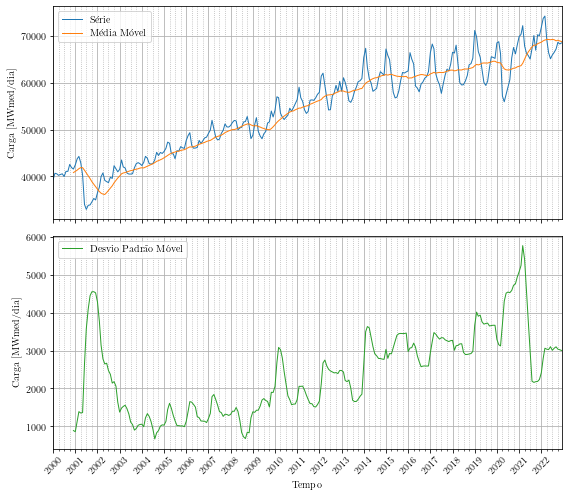

In [12]:
from functions import plot_rolling

plot_rolling(df.index, df.load, window=12, saveFileName=fig_folder+f"data_{region}_month_mean_stationarity")

### Augmented Dickey–Fuller (ADF)

In [13]:
from functions import adf_test

adf_test(df.load)

ADF Statistic:  -0.43298728298090033
P-Value:  0.9044436869745505
Critical Values:
	1%: -3.46
	5%: -2.87
	10%: -2.57
Not Stationary


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

In [14]:
from functions import kpss_test

kpss_test(df.load)

KPSS Statistic:  0.3096896370582317
P-Value:  0.01
Critical Values:
	10%: 0.12
	5%: 0.15
	2.5%: 0.18
	1%: 0.22
Not Stationary


d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Conclusões

A série temporal não é estacionária.
Há tendência de crescimento e sazonalidade.
Autorregressão não é um modelo adequado.

# Variação

Transforma-se os dados absolutos para variação: *differencing*.
Considera-se $t = \{1, 2, \dotsc, N\}$.

$\Delta y(t) = y(t) - y(t-1)$

,load,load_diff
timestamp,,
2000-01-01,39253.390659,NaN
2000-02-01,40665.397845,1412.007186
2000-03-01,40556.063720,-109.334124
2000-04-01,40214.947917,-341.115804
2000-05-01,40408.382258,193.434341
...,...,...
2022-08-01,66518.460905,574.422369
2022-09-01,67232.268617,713.807712
2022-10-01,68675.057032,1442.788415


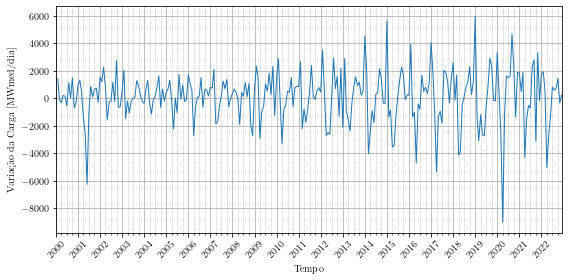

In [15]:
df["load_diff"] = df.load.diff()

display(df)
plot_data(df.index, df.load_diff, ylabel="Variação da Carga [MWmed/dia]", saveFileName=fig_folder+f"data_{region}_month_mean_diff")

# Análise de Dados

In [16]:
display(df.load_diff.describe())

count     275.000000
mean      106.515669
std      1849.654678
min     -9034.283157
25%      -711.570572
50%       221.303036
75%      1215.942885
max      5920.843484
Name: load_diff, dtype: float64

## Testes de Estacionariedade

### Média e Desvio Padrão Móveis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


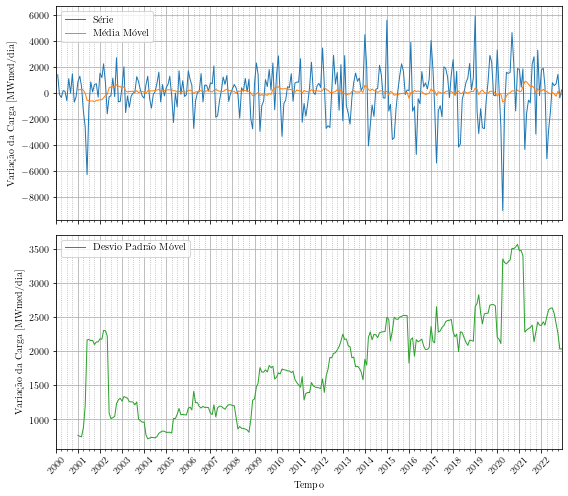

In [17]:
from functions import plot_rolling

plot_rolling(df.index, df.load_diff, window=12, ylabel="Variação da Carga [MWmed/dia]", saveFileName=fig_folder+f"data_{region}_month_mean_diff_stationarity")

### Augmented Dickey–Fuller (ADF)

In [18]:
from functions import adf_test

adf_test(df.load_diff[1:])

ADF Statistic:  -5.4598840202954415
P-Value:  2.532549090821271e-06
Critical Values:
	1%: -3.46
	5%: -2.87
	10%: -2.57
Stationary


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

In [19]:
from functions import kpss_test

kpss_test(df.load_diff[1:])

KPSS Statistic:  0.014585729022093116
P-Value:  0.1
Critical Values:
	10%: 0.12
	5%: 0.15
	2.5%: 0.18
	1%: 0.22
Stationary


d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Conclusões

A série é "aproximadamente estacionária".
Tendência de crescimento foi eliminada na média.
Ainda há sazonalidade.

## Correlações

### Autorrelação Parcial

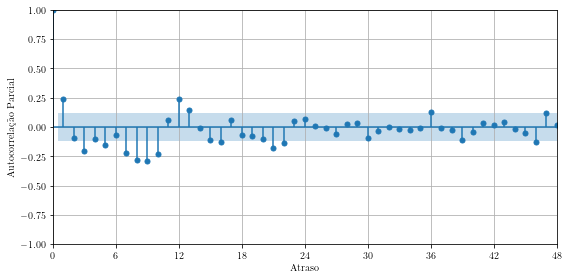

In [20]:
from functions import plot_partial_autocorrelation

plot_partial_autocorrelation(df.load_diff[1:], lags=4*12, alpha=0.05, saveFileName=fig_folder+f"data_{region}_month_mean_diff_partial_autocorrelation")

# Autorregressão

Considera-se que o modelo é de ordem $n$.
Considera-se $t = \{1, 2, \dotsc, N\}$.

Autorregressão para $t > n$:
\begin{align*}
\Delta y(t)
&= \theta_0 + \theta_1 \, \Delta y(t-1) + \theta_2 \, \Delta y(t-2) + \dotsb + \theta_n \, \Delta y(t-n) + \varepsilon(t)
\\
&= \vec{\theta}^{\,T} \, \vec{\phi}(t) + \varepsilon(t)
\end{align*}
$$
\vec{\theta} = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \theta_2 \\ \vdots \\ \theta_n \end{bmatrix}
\qquad
\vec{\phi}(t) = \begin{bmatrix} 1 \\ \Delta y(t-1) \\ \Delta y(t-2) \\ \vdots \\ \Delta y(t-n) \end{bmatrix}
$$

Em notação matricial:
$$
\vec{\Delta y} = \mathbf{\Phi} \, \vec{\theta} + \vec{\varepsilon}
$$
$$
\vec{\Delta y} = \begin{bmatrix} \Delta y(n+1) \\ \Delta y(n+2) \\ \vdots \\ \Delta y(N) \end{bmatrix}
\qquad
\mathbf{\Phi} = \begin{bmatrix} \vec{\phi}^{\,T}(n+1) \\ \vec{\phi}^{\,T}(n+2) \\ \vdots \\ \vec{\phi}^{\,T}(N) \end{bmatrix}
\qquad
\vec{\varepsilon} = \begin{bmatrix} \varepsilon(n+1) \\ \varepsilon(n+2) \\ \vdots \\ \varepsilon(N) \end{bmatrix}
$$

Deseja-se determinar os parâmetros $\vec{\theta}^\star$ que minimizam o erro quadrático médio:
$$
e(t) = \Delta y(t) - \vec{\theta}^{\,T} \, \vec{\phi}(t)
\qquad
\vec{e} = \begin{bmatrix} e(n+1) \\ e(n+2) \\ \vdots \\ e(N) \end{bmatrix}
$$
$$
J\left(\vec{\theta}\right)
= \dfrac{1}{N} \, \sum_{t=n+1}^{N} \left(e(t)\right)^2
= \dfrac{1}{N} \, \vec{e}^{\,T} \, \vec{e}
$$
$$
\vec{\theta}^\star = \underset{\vec{\theta}}{\arg\min} \left\{J\left(\vec{\theta}\right)\right\}
$$

## Divisão dos Dados em Treino e Validação

In [21]:
import math

n = 22 # Autoregressive order
N = len(df) - 1 # -1 because of differencing

train_set = 0.8 # Percentage of data used in training
m = math.floor(train_set * N)

train = df.load_diff.values[1:m]
test  = df.load_diff.values[m-n:]

t_train = df.index[1:m]
t_test  = df.index[m-n:]

## Implementações

### Batelada Matricial

$$
\left(\mathbf{\Phi}^{\,T} \, \mathbf{\Phi}\right) \, \vec{\theta} = \mathbf{\Phi}^{\,T} \, \vec{z}
$$

Constant:  627.1562515797004


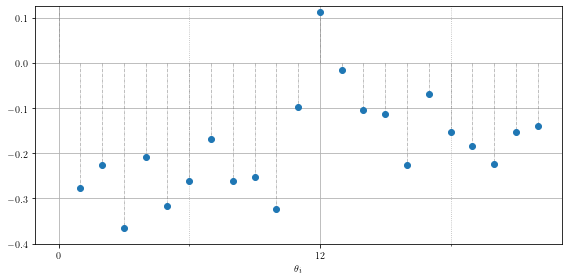

Erro Quadrático Médio: 1216113.4569954416


In [22]:
from functions import autoregression_batch, plot_params

theta_m, mse_train_m = autoregression_batch(train, n)
plot_params(theta_m)
print(f"Erro Quadrático Médio: {mse_train_m}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


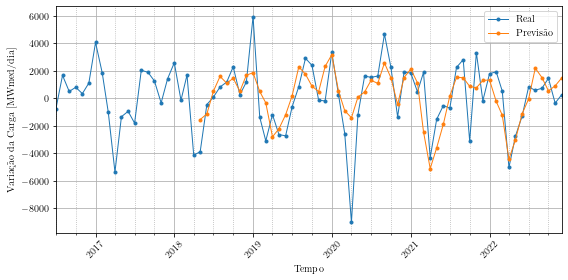

Erro Quadrático Médio: 3453455.7201341134


In [23]:
from functions import apply_autorregresion, plot_test
from sklearn.metrics import mean_squared_error

z_m = apply_autorregresion(test, theta_m)

plot_test(t_test, test, t_test[n:], z_m, ylabel="Variação da Carga [MWmed/dia]", saveFileName=fig_folder+f"forecast_{region}_month_mean_diff_batch")

mse_m = mean_squared_error(test[n:], z_m)
print(f"Erro Quadrático Médio: {mse_m}")

### Batelada por Somatório

$$
\mathbf{P}^{-1} = \sum_{t=n+1}^{N} \phi(t) \, \phi^{\,T}(t)
$$
$$
\mathbf{P}^{-1} \, \vec{\theta} = \sum_{t=n+1}^{N} y(t) \, \phi(t)
$$

Constant:  627.1562515796996


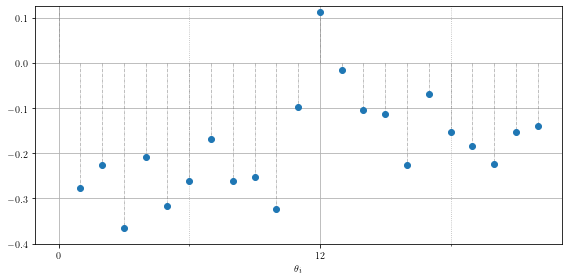

Erro Quadrático Médio: 1216113.456995442


In [24]:
from functions import autoregression_batch_sum, plot_params

theta_s, mse_train_s, _ = autoregression_batch_sum(train, n)
plot_params(theta_s)
print(f"Erro Quadrático Médio: {mse_train_s}")

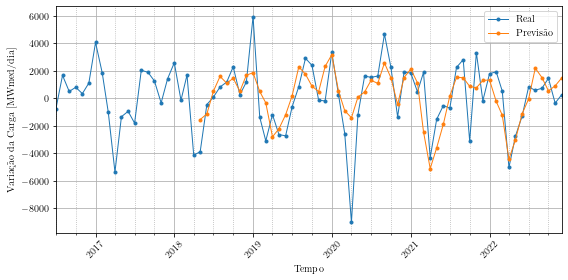

Erro Quadrático Médio: 3453455.7201341144


In [25]:
from functions import apply_autorregresion, plot_test
from sklearn.metrics import mean_squared_error

z_s = apply_autorregresion(test, theta_s)

plot_test(t_test, test, t_test[n:], z_s, ylabel="Variação da Carga [MWmed/dia]")

mse_s = mean_squared_error(test[n:], z_s)
print(f"Erro Quadrático Médio: {mse_s}")

### Recursiva

\begin{align*}
\epsilon(t) 
&= \Delta y(t) - \vec{\theta}^{\,T}(t-1) \, \vec{\phi}(t)
\\
\vec{\kappa}(t) 
&= \dfrac{1}{1 + \vec{\phi}^{\,T}(t) \, \mathbf{P}(t-1) \, \vec{\phi}(t)} \, \mathbf{P}(t-1) \, \vec{\phi}(t)
\\
\vec{\theta}(t)
&= \vec{\theta}(t-1) + \vec{\kappa}(t) \, \epsilon(t)
\\
\mathbf{P}(t) 
&= \mathbf{P}(t-1) - \vec{\kappa}(t) \, \vec{\phi}^{\,T}(t) \, \mathbf{P}(t-1)
\end{align*}

#### Inicialização Padrão

\begin{align*}
\vec{\theta}(0) &= \vec{0}
\\
\mathbf{P}(0) &= \mathbf{I}
\end{align*}

Constant:  620.7210215726384


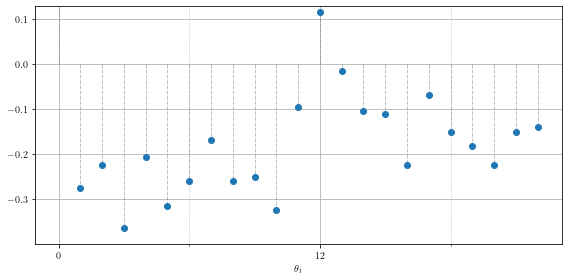

Erro Quadrático Médio: 1216133.7335844042


In [26]:
from functions import autoregression_recursive, plot_params

theta_r, mse_train_r, _ = autoregression_recursive(train, n)
plot_params(theta_r)
print(f"Erro Quadrático Médio: {mse_train_r}")

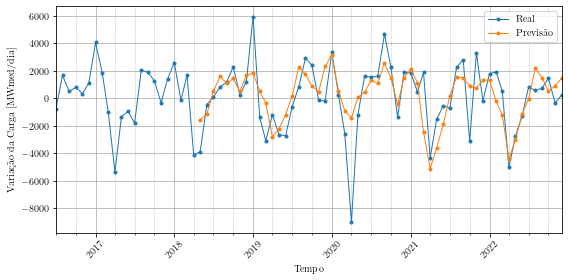

Erro Quadrático Médio: 3453441.1467751493


In [27]:
from functions import apply_autorregresion, plot_test
from sklearn.metrics import mean_squared_error

z_r = apply_autorregresion(test, theta_r)

plot_test(t_test, test, t_test[n:], z_r, ylabel="Variação da Carga [MWmed/dia]")

mse_r = mean_squared_error(test[n:], z_r)
print(f"Erro Quadrático Médio: {mse_r}")

#### Inicialização Exata

Como o modelo é autorregressivo, necessita-se $(n + 1) + n = 2 \, n + 1$ dados para que a equação da implementação por batelada tenha solução única.
Determina-se $\vec{\theta}(2 \, n + 1)$ e $\mathbf{P}(2 \, n + 1)$ por batelada, após prossegue-se pela implementação recursiva.

Constant:  627.1562515796954


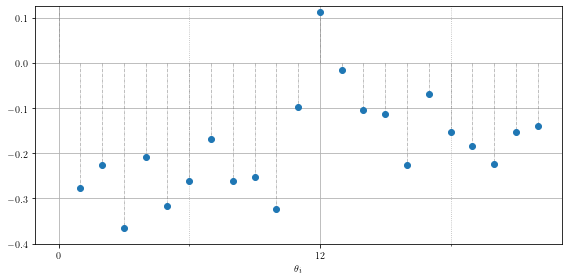

Erro Quadrático Médio: 1216113.456995442


In [28]:
from functions import autoregression_batch_sum, autoregression_recursive, plot_params

theta_0, _, P_0 = autoregression_batch_sum(train[:2*n+1], n)
theta_r0, _, _ = autoregression_recursive(train[n+1:], n, theta_0, P_0)
plot_params(theta_r0)

mse_train_r0 = mean_squared_error(train[n:], apply_autorregresion(train, theta_r0))
print(f"Erro Quadrático Médio: {mse_train_r0}")

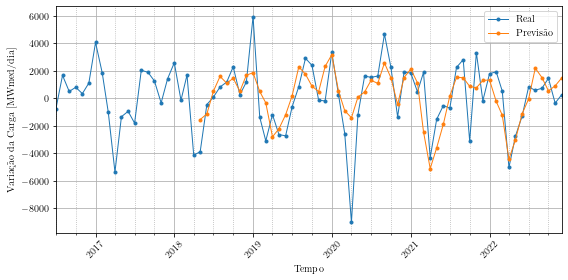

Erro Quadrático Médio: 3453455.7201341134


In [29]:
from functions import apply_autorregresion, plot_test
from sklearn.metrics import mean_squared_error

z_r0 = apply_autorregresion(test, theta_r0)

plot_test(t_test, test, t_test[n:], z_r0, ylabel="Variação da Carga [MWmed/dia]")

mse_r0 = mean_squared_error(test[n:], z_r0)
print(f"Erro Quadrático Médio: {mse_r0}")

## Variação do Número de Parâmetros

### Efeito sobre o Erro Quadrático Médio

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


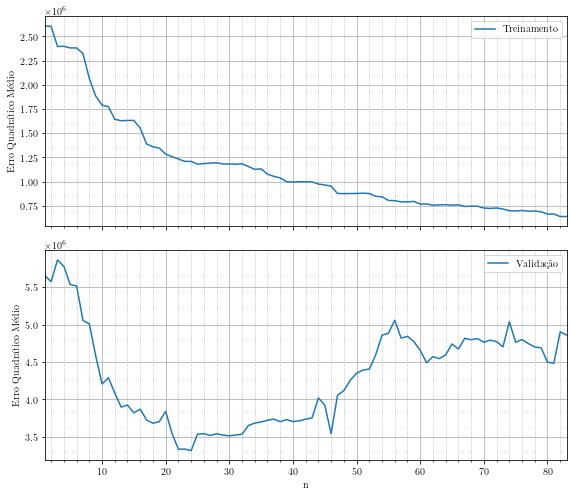

In [30]:
from functions import mse_backsteps

_ = mse_backsteps(df.load_diff[1:].values, n_range=range(1,7*12), saveFileName=fig_folder+f"data_{region}_month_mean_diff_n")

# Validação Cruzada

## *K-Fold*

### Parâmetros

In [31]:
n = 22 # Autoregressive order
k = 5 # Number of Folds

### Implementação com Grupos Sequenciais

Constants:
Fold 1: 590.6335818242982
Fold 2: 589.6755060778381
Fold 3: 552.1654728923162
Fold 4: 682.9988271121221
Fold 5: 617.5109190058138


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


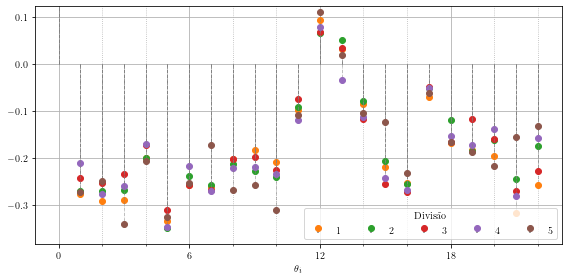

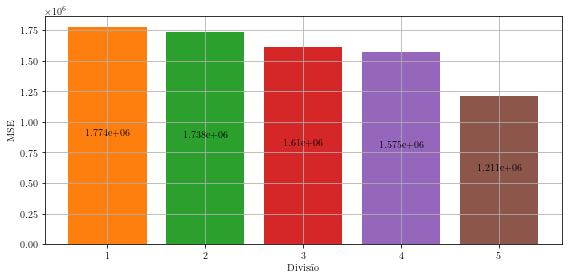

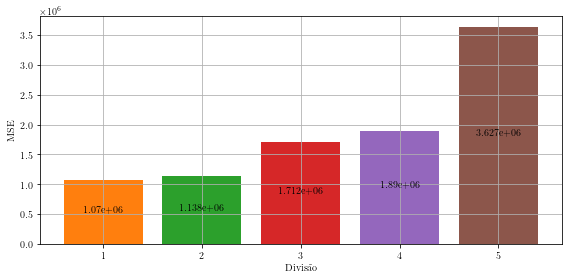

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


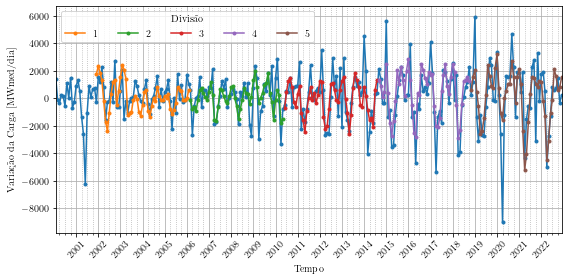

In [32]:
from functions import k_fold_cross_validation

fold_thetas, _, _, fold_test_mses, _, fold_train_mses = k_fold_cross_validation(df.index[1:], df.load_diff[1:], n, k, ylabel="Variação da Carga [MWmed/dia]",
  saveFileName=[fig_folder+f"k_fold_{region}_month_mean_diff_param", "", "", fig_folder+f"k_fold_{region}_month_mean_diff_test"])

# Aplicação para Previsão

## Divisão dos Dados em Treino e Validação

In [33]:
import math

n = 22 # Autoregressive order
N = len(df) - 1 # -1 because of differencing

train_set = 0.8 # Percentage of data used in training
m = math.floor(train_set * N)

train = df.load_diff.values[1:m]
test  = df.load_diff.values[m-n:]
test_abs = df.load.values[m-n:]

t_train = df.index[1:m]
t_test  = df.index[m-n:]

## Autorregressão

Constant:  627.1562515797004


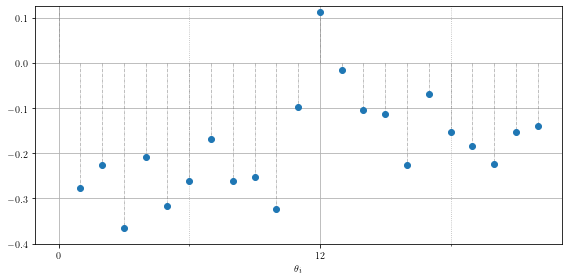

Erro Quadrático Médio: 1216113.4569954416


In [34]:
from functions import autoregression_batch, plot_params

theta, mse = autoregression_batch(train, n)
plot_params(theta)
print(f"Erro Quadrático Médio: {mse}")

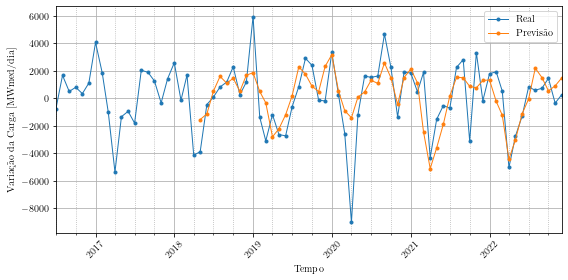

In [35]:
from functions import apply_autorregresion, plot_test

z = apply_autorregresion(test, theta)
plot_test(t_test, test, t_test[n:], z, ylabel="Variação da Carga [MWmed/dia]")

## Retorno para Valores Absolutos

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


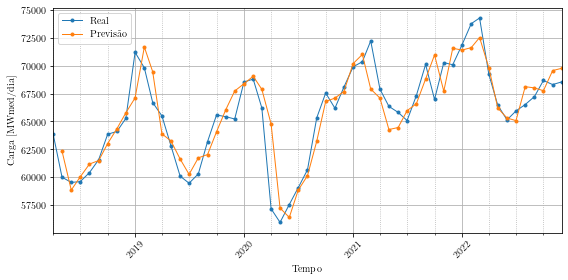

Erro Quadrático Médio: 3453455.720134116


In [36]:
from functions import plot_test
from sklearn.metrics import mean_squared_error

y = []
for i in range(len(z)):
  y.append(test_abs[n-1+i] + z[i])
  
plot_test(t_test[n-1:], test_abs[n-1:], t_test[n:], y, saveFileName=fig_folder+f"forecast_{region}_month_mean")

mse = mean_squared_error(test_abs[n:], y)
print(f"Erro Quadrático Médio: {mse}")